# Two-Layer-Fully-Conected Neural Network 

**This material is heavily based on the popular Standford CS231n lecture material.** [Please check on their website for more detailed information](https://cs231n.github.io/).

In [4]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 10,
})

from utils import *

np.set_printoptions(precision=5, suppress=True)


![](./images/2fcnn.png)

In [ ]:
class TwoLayerNet():
    """
    A two-layer fully-connected neural network. The net has an input dimension of
    N, a hidden layer dimension of H, and performs classification over C classes.
    We train the network with a softmax loss function and L2 regularization on the
    weight matrices. The network uses a ReLU nonlinearity after the first fully
    connected layer.

    In other words, the network has the following architecture:

    input - fully connected layer - ReLU - fully connected layer - softmax

    The outputs of the second fully-connected layer are the scores for each class.
    """

    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
        """
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:

        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, C)
        b2: Second layer biases; has shape (C,)

        Inputs:
        - input_size: The dimension D of the input data.
        - hidden_size: The number of neurons H in the hidden layer.
        - output_size: The number of classes C.
        """
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def loss(self, X, Y, reg=0.0):
        """
        Compute the loss and gradients for a two layer fully connected neural
        network.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels. Y[i] is the label for X[i], and each y[i] is
        an integer in the range 0 <= Y[i] < C. This parameter is optional; if it
        is not passed then we only return scores, and if it is passed then we
        instead return the loss and gradients.
        - reg: Regularization strength.

        Returns:
        - loss: Loss (data loss and regularization loss) for this batch of training
        samples.
        - grads: Dictionary mapping parameter names to gradients of those parameters
        with respect to the loss function; has the same keys as self.params.
        """
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        # Compute the forward pass
        fc1 = X.dot(W1) + b1     # fully connected
        X2 = np.maximum(0, fc1)  # ReLU
        F = X2.dot(W2) + b2 # fully connected
        
        # Compute the loss 
        F = F - np.max(F, axis=1).reshape(-1,1)
        expF = np.exp(F)
        softmax = expF/np.sum(expF, axis=1).reshape(-1,1) 
        loss = np.sum(-np.log(softmax[range(N),Y])) / N + reg  * (np.sum(W2 * W2) + np.sum( W1 * W1 ))
        
        # Backward pass: compute gradients
        grads = {}
        softmax[np.arange(N) ,Y] -= 1
        softmax /= N

        # W2 gradient
        dW2 = X2.T.dot(softmax)   # [HxN] * [NxC] = [HxC]

        # b2 gradient
        db2 = softmax.sum(axis=0)

        # W1 gradient
        dW1 = softmax.dot(W2.T)   # [NxC] * [CxH] = [NxH]
        dfc1 = dW1 * (fc1>0)      # [NxH] . [NxH] = [NxH]
        dW1 = X.T.dot(dfc1)       # [DxN] * [NxH] = [DxH]

        # b1 gradient
        db1 = dfc1.sum(axis=0)

        # regularization gradient
        dW1 += reg * 2 * W1
        dW2 += reg * 2 * W2

        grads = {'W1':dW1, 'b1':db1, 'W2':dW2, 'b2':db2}
        
        return loss, grads


    def train(self, X, Y,
                learning_rate=1e-3, learning_rate_decay=0.98,
                reg=1e-5, num_iters=200,
                batch_size=200, verbose=False):
        """
        Train this neural network using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) giving training data.
        - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
        X[i] has label c, where 0 <= c < C.
        - X_val: A numpy array of shape (N_val, D) giving validation data.
        - y_val: A numpy array of shape (N_val,) giving validation labels.
        - learning_rate: Scalar giving learning rate for optimization.
        - learning_rate_decay: Scalar giving factor used to decay the learning rate
        after each epoch.
        - reg: Scalar giving regularization strength.
        - num_iters: Number of steps to take when optimizing.
        - batch_size: Number of training examples to use per step.
        - verbose: boolean; if true print progress during optimization.
        """
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)

        # Use SGD to optimize the parameters in self.model
        loss_history = []
        train_acc_history = []

        for it in range(num_iters):
            X_batch = None
            Y_batch = None

            # Stochastic gradient descent
            batch_indices = np.random.choice(num_train, batch_size)
            X_batch = X[batch_indices]
            Y_batch = Y[batch_indices]
            
            # Compute loss and gradients using the current minibatch
            loss, grads = self.loss(X_batch, Y_batch, reg=reg)
            loss_history.append(loss)

            for key in self.params:
                self.params[key] -= learning_rate * grads[key]

            if verbose and it % 10 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

            # Every epoch, check train and val accuracy and decay learning rate.
            if it % iterations_per_epoch == 0:
                # Check accuracy
                train_acc = (self.predict(X_batch) == Y_batch).mean()
                train_acc_history.append(train_acc)

                # Decay learning rate
                learning_rate *= learning_rate_decay

        return {
        'loss_history': loss_history,
        'train_acc_history': train_acc_history,
        }


    def predict(self, X):
        """
        Use the trained weights of this two-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: A numpy array of shape (N, D) giving N D-dimensional data points to
        classify.

        Returns:
        - Y_pred: A numpy array of shape (N,) giving predicted labels for each of
        the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
        to have class c, where 0 <= c < C.
        """

        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']

        # Compute the forward pass
        fc1 = X.dot(W1) + b1     # fully connected
        X2 = np.maximum(0, fc1)  # ReLU
        scores = X2.dot(W2) + b2 # fully connected
    
        y_pred = np.argmax( scores, axis=1)
        
        return y_pred

## Breast Cancer Wisconsin

### Load training and test dataset

In [36]:
data = np.loadtxt("./datasets/breast_cancer/wdbc.data", delimiter=",", dtype=str)
X = np.float32(data[:, 2:12])  # 10 dimensions

# Diagnosis (M = malignant, B = benign)
Y = np.zeros(X.shape[0], dtype=np.int32) 
Y[np.where(data[:,1]=='M')] = 1
Y[np.where(data[:,1]=='B')] = 0

print("Dimension numbers :", X.shape[1])
print("Number of data    :", X.shape[0])
print("Labels            :", np.unique(Y))

# For the NN
input_size  = X.shape[1]
num_classes = len(np.unique(Y))

Dimension numbers : 10
Number of data    : 569
Labels            : [0 1]


In [39]:
X_train = X[0:400, :]
Y_train = Y[0:400]
X_test  = X[401:, :]
Y_test  = Y[401:]

num_test = X_test.shape[0]

### Finding good paramteters

* `hidden_size = ???`
* `learning_rate = ???`
* `reg = ???`

In [56]:
best_net = None # store the best model into this 
best_val = -1
best_stats = []
#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on the previous exercises.                          #
#################################################################################
# generate random hyperparameters given ranges for each of them
def generate_random_hyperparams(lr_min, lr_max, reg_min, reg_max, h_min, h_max):
    lr = 10**np.random.uniform(lr_min,lr_max)
    reg = 10**np.random.uniform(reg_min,reg_max)
    hidden = np.random.randint(h_min, h_max)
    return lr, reg, hidden


# get random hyperparameters given arrays of potential values
def random_search_hyperparams(lr_values, reg_values, h_values):
    lr = lr_values[np.random.randint(0,len(lr_values))]
    reg = reg_values[np.random.randint(0,len(reg_values))]
    hidden = h_values[np.random.randint(0,len(h_values))]
    return lr, reg, hidden


# Set a seed for results reproduction
np.random.seed(0)

# Use of random search for hyperparameter search
for i in range(20): # 20 trials
    # Given a set of potential values, increase the number of iterations
    lr, reg, hidden_size = random_search_hyperparams([0.1, 0.01, 0.001, 0.0001], [0.01, 0.05, 0.1, 0.15, 0.2], [50, 80, 100, 120, 150, 180, 200, 250, 300])
    
    # Create a two-layer network
    net = TwoLayerNet(input_size, hidden_size, num_classes)
    
    # Train the network
    stats = net.train(X_train, Y_train,
                num_iters=2000, batch_size=200,
                learning_rate=lr, learning_rate_decay=0.95,
                reg=reg, verbose=False)

    # Predict on the training set
    train_accuracy = (net.predict(X_train) == Y_train).mean()
    
    # Predict on the validation set
    val_accuracy = (net.predict(X_test) == Y_test).mean()
    
    # Save best values
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_net = net
        best_stats = stats
    
    # Print results
    print('lr %e reg %e hid %d  train accuracy: %f val accuracy: %f' % (
                lr, reg, hidden_size, train_accuracy, val_accuracy))
print('best validation accuracy achieved: %f' % best_val)

lr 1.000000e-01 reg 1.000000e-02 hid 120  train accuracy: 0.567500 val accuracy: 0.773810
lr 1.000000e-03 reg 5.000000e-02 hid 200  train accuracy: 0.432500 val accuracy: 0.226190
lr 1.000000e-04 reg 1.000000e-01 hid 100  train accuracy: 0.770000 val accuracy: 0.904762
lr 1.000000e-02 reg 1.500000e-01 hid 200  train accuracy: 0.567500 val accuracy: 0.773810
lr 1.000000e-02 reg 1.000000e-01 hid 250  train accuracy: 0.717500 val accuracy: 0.607143
lr 1.000000e-03 reg 2.000000e-01 hid 120  train accuracy: 0.432500 val accuracy: 0.226190
lr 1.000000e-04 reg 1.000000e-02 hid 120  train accuracy: 0.857500 val accuracy: 0.827381
lr 1.000000e-01 reg 1.000000e-02 hid 250  train accuracy: 0.567500 val accuracy: 0.773810
lr 1.000000e-02 reg 2.000000e-01 hid 180  train accuracy: 0.682500 val accuracy: 0.577381
lr 1.000000e-04 reg 5.000000e-02 hid 50  train accuracy: 0.570000 val accuracy: 0.779762
lr 1.000000e-04 reg 5.000000e-02 hid 120  train accuracy: 0.757500 val accuracy: 0.904762
lr 1.000000

### Run the classifier with the found parameters

* `hidden_size = 100`
* `learning_rate = 1e-4`
* `reg = 0.1`

In [59]:
hidden_size = 100

net = TwoLayerNet(input_size, hidden_size, num_classes)
stats = net.train(X_train, Y_train, learning_rate=1e-4, reg=0.1, num_iters=1000, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_test) == Y_test).mean()
print('Validation accuracy: ', val_acc)

iteration 0 / 1000: loss 0.693152
iteration 10 / 1000: loss 0.693134
iteration 20 / 1000: loss 0.693110
iteration 30 / 1000: loss 0.693084
iteration 40 / 1000: loss 0.693073
iteration 50 / 1000: loss 0.693061
iteration 60 / 1000: loss 0.693057
iteration 70 / 1000: loss 0.693030
iteration 80 / 1000: loss 0.693029
iteration 90 / 1000: loss 0.693024
iteration 100 / 1000: loss 0.693003
iteration 110 / 1000: loss 0.692992
iteration 120 / 1000: loss 0.692974
iteration 130 / 1000: loss 0.692967
iteration 140 / 1000: loss 0.692970
iteration 150 / 1000: loss 0.692945
iteration 160 / 1000: loss 0.692956
iteration 170 / 1000: loss 0.692934
iteration 180 / 1000: loss 0.692942
iteration 190 / 1000: loss 0.692902
iteration 200 / 1000: loss 0.692924
iteration 210 / 1000: loss 0.692893
iteration 220 / 1000: loss 0.692919
iteration 230 / 1000: loss 0.692905
iteration 240 / 1000: loss 0.692869
iteration 250 / 1000: loss 0.692877
iteration 260 / 1000: loss 0.692896
iteration 270 / 1000: loss 0.692878
ite

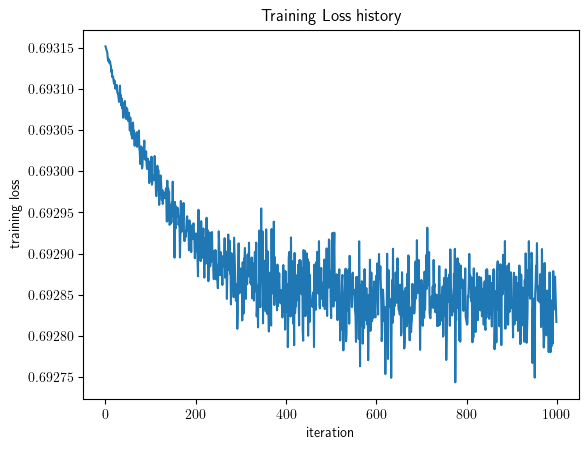

In [60]:
# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()